<a href="https://colab.research.google.com/github/Aditya-Shandilya1182/extreme_classification/blob/main/Test_For_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
import numpy as np


In [2]:
import math

In [25]:
class ParameterizedGeLU(tf.keras.layers.Layer):
    def __init__(self, alpha_initializer='GlorotNormal', beta_initializer='GlorotNormal', **kwargs):
        super(ParameterizedGeLU, self).__init__(**kwargs)
        self.alpha_initializer = initializers.get(alpha_initializer)
        self.beta_initializer = initializers.get(beta_initializer)
        self.alpha_values = []
        self.beta_values = []

    def build(self, input_shape):
        self.alpha = self.add_weight(shape=(1,), initializer=self.alpha_initializer, name='alpha')
        self.beta = self.add_weight(shape=(1,), initializer=self.beta_initializer, name='beta')
        super(ParameterizedGeLU, self).build(input_shape)

    def call(self, inputs, training = None):
        alpha = self.alpha
        beta = self.beta
        const = math.sqrt(2 / math.pi)
        if training:
            self.alpha_values.append(alpha)
            self.beta_values.append(beta)
        return self.beta * 0.5 * inputs * (1 + tf.tanh(const * (self.alpha * inputs + 0.044715 * tf.pow(inputs, 3))))

    def get_config(self):
        config = super(ParameterizedGeLU, self).get_config()
        config.update({
            'alpha_initializer': initializers.serialize(self.alpha_initializer),
            'beta_initializer': initializers.serialize(self.beta_initializer)
        })
        return config

In [13]:
class MultiHeadSelfAttention(tf.keras.layers.Layer):

   def __init__(self, num_heads, d_model, dropout_rate=0.1):
      super(MultiHeadSelfAttention, self).__init__()
      self.num_heads = num_heads
      self.d_model = d_model
      assert self.d_model % self.num_heads == 0
      self.depth = self.d_model // self.num_heads
      self.query_dense = Dense(self.d_model)
      self.key_dense = Dense(self.d_model)
      self.value_dense = Dense(self.d_model)
      self.dropout = Dropout(dropout_rate)
      self.final_dense = Dense(self.d_model)

   def split_heads(self, inputs, batch_size):
      inputs = tf.reshape(inputs, (batch_size, -1, self.num_heads, self.depth))
      return tf.transpose(inputs, perm=[0, 2, 1, 3])

   def call(self, inputs):
      batch_size = tf.shape(inputs)[0]
      query = self.query_dense(inputs)
      key = self.key_dense(inputs)
      value = self.value_dense(inputs)
      query = self.split_heads(query, batch_size)
      key = self.split_heads(key, batch_size)
      value = self.split_heads(value, batch_size)
      scaled_attention, attention_weights = self.scaled_dot_product_attention(query, key, value)
      scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
      concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
      outputs = self.final_dense(concat_attention)
      return outputs

   def scaled_dot_product_attention(self, query, key, value):
      matmul_qk = tf.matmul(query, key, transpose_b=True)
      dk = tf.cast(tf.shape(key)[-1], tf.float32)
      scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
      attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
      output = tf.matmul(attention_weights, value)
      return output, attention_weights

In [26]:
class TextClassificationModel:

  def __init__(self, vocab_size, embedding_dim, max_length, num_classes):
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.max_length = max_length
    self.num_classes = num_classes

  def build_model(self):
    inputs = Input(shape=(self.max_length,))
    embedding_layer = Embedding(self.vocab_size, self.embedding_dim, input_length=self.max_length)(inputs)
    attention_output = MultiHeadSelfAttention(num_heads=8, d_model=self.embedding_dim)(embedding_layer)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output + embedding_layer)
    ffnn_output = Dense(128)(attention_output)
    gelu_layer = ParameterizedGeLU()(ffnn_output)  # Using Parameterized GeLU activation
    ffnn_output = Dense(64)(gelu_layer)
    gelu_layer = ParameterizedGeLU()(ffnn_output)  # Using Parameterized GeLU activation
    ffnn_output = Dense(32)(gelu_layer)
    gelu_layer = ParameterizedGeLU()(ffnn_output)  # Using Parameterized GeLU activation
    global_pooling = GlobalAveragePooling1D()(gelu_layer)
    outputs = Dense(1, activation='sigmoid')(global_pooling)
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [15]:
import matplotlib.pyplot as plt

def plot_alpha_beta_values(model):
    # Access alpha and beta values
    alpha_values = model.layers[-5].alpha_values
    beta_values = model.layers[-5].beta_values

    # Plot alpha and beta values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(alpha_values)
    plt.title('Alpha Values')
    plt.xlabel('Training Iterations')
    plt.ylabel('Alpha')

    plt.subplot(1, 2, 2)
    plt.plot(beta_values)
    plt.title('Beta Values')
    plt.xlabel('Training Iterations')
    plt.ylabel('Beta')

    plt.tight_layout()
    plt.show()


In [43]:
class SaveAlphaBetaValues(tf.keras.callbacks.Callback):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}:")
        for i, layer in enumerate(self.model.layers):
            if isinstance(layer, ParameterizedGeLU):
                alpha_values = layer.alpha_values[-1]
                beta_values = layer.beta_values[-1]
                print(f"Layer {i + 1}: Alpha = {alpha_values}, Beta = {beta_values}")


In [44]:
# Example usage:
vocab_size = 10000
embedding_dim = 128
max_length = 256
num_classes = 2  # binary classification task

text_classifier = TextClassificationModel(vocab_size, embedding_dim, max_length, num_classes)
model = text_classifier.build_model()
model.summary()


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 256)]                0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 256, 128)             1280000   ['input_7[0][0]']             
                                                                                                  
 multi_head_self_attention_  (None, None, 128)            66048     ['embedding_6[0][0]']         
 6 (MultiHeadSelfAttention)                                                                       
                                                                                                  
 tf.__operators__.add_6 (TF  (None, 256, 128)             0         ['multi_head_self_attent

In [45]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [9]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=max_length)
x_test = pad_sequences(x_test, maxlen=max_length)


17464789/17464789 [==============================] - 2s 0us/step


In [10]:
x_train.shape

(25000, 256)

In [46]:
history = model.fit(x_train, y_train, epochs=10, batch_size=512, validation_data=(x_test, y_test), callbacks=[SaveAlphaBetaValues(model)])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/10
49/49 [==============================] - ETA: 0s - loss: 0.5329 - accuracy: 0.7118Epoch 1:
Layer 7: Alpha = <tf.Variable 'parameterized_ge_lu_18/alpha:0' shape=(1,) dtype=float32, numpy=array([-0.9078276], dtype=float32)>, Beta = <tf.Variable 'parameterized_ge_lu_18/beta:0' shape=(1,) dtype=float32, numpy=array([-0.23513031], dtype=float32)>
Layer 9: Alpha = <tf.Variable 'parameterized_ge_lu_19/alpha:0' shape=(1,) dtype=float32, numpy=array([-1.8396482], dtype=float32)>, Beta = <tf.Variable 'parameterized_ge_lu_19/beta:0' shape=(1,) dtype=float32, numpy=array([0.7656796], dtype=float32)>
Layer 11: Alpha = <tf.Variable 'parameterized_ge_lu_20/alpha:0' shape=(1,) dtype=float32, numpy=array([1.1506943], dtype=float32)>, Beta = <tf.Variable 'parameterized_ge_lu_20/beta:0' shape=(1,) dtype=float32, numpy=array([0.49669954], dtype=float32)>
49/49 [==============================] - 19s 321ms/step - loss: 0.5329 - accuracy: 0.7118 - val_loss: 0.3409 - val_accuracy: 0.8544
Epoch 2/10

In [47]:
alpha_values = [
    [-0.9078276, -0.91585815, -0.9211506, -0.9196009, -0.9167609, -0.9131289, -0.913774, -0.9131289, -0.9117558, -0.91038656],
    [-1.8396482, -1.8335428, -1.8337141, -1.8371782, -1.8428754, -1.8458687, -1.8513333, -1.8545464, -1.8562541, -1.8542687],
    [1.1506943, 1.143222, 1.1436889, 1.148357, 1.1533614, 1.1565748, 1.1613268, 1.164579, 1.1651702, 1.1613015]
]

beta_values = [
    [-0.23513031, -0.23708859, -0.24217658, -0.24351808, -0.24517061, -0.24445693, -0.24992605, -0.25095886, -0.2532425, -0.25302494],
    [0.7656796, 0.76815623, 0.773654, 0.7747966, 0.77610934, 0.77502304, 0.7803302, 0.7811793, 0.7833886, 0.78323907],
    [0.49669954, 0.50012535, 0.50583607, 0.5066621, 0.50765294, 0.50636244, 0.5114451, 0.51208407, 0.5143146, 0.5144789]
]


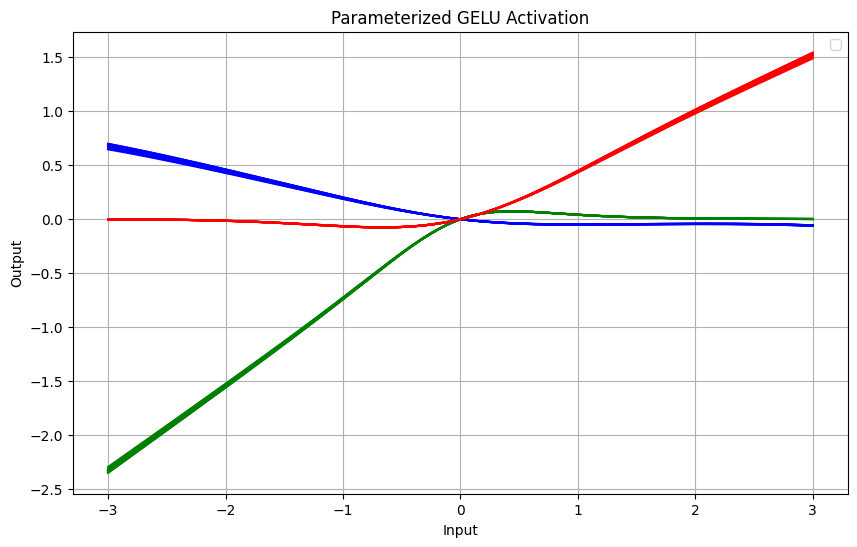

In [56]:

def gelu(x, alpha, beta):
    const = math.sqrt(2 / math.pi)
    return beta * 0.5 * x * (1 + np.tanh(const * (alpha * x + 0.044715 * np.power(x, 3))))

plt.figure(figsize=(10, 6))

colors = ['blue', 'green', 'red']  # Different colors for different layers

for i, (alpha_val, beta_val) in enumerate(zip(alpha_values, beta_values)):
    for alpha, beta in zip(alpha_val, beta_val):
        y_values = gelu(x_values, alpha, beta)
        plt.plot(x_values, y_values, color=colors[i])

plt.title('Parameterized GELU Activation')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
alpha_values = []
beta_values = []

for layer in model.layers:
    if isinstance(layer, ParameterizedGeLU):
        alpha_values.append(layer.alpha.numpy())
        beta_values.append(layer.beta.numpy())

# Assuming the alpha and beta values are the same across all ParameterizedGeLU layers for simplicity
alpha_values = np.array(alpha_values).flatten()
beta_values = np.array(beta_values).flatten()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def gelu(x, alpha, beta):
    const = math.sqrt(2 / math.pi)
    return beta * 0.5 * x * (1 + np.tanh(const * (alpha * x + 0.044715 * np.power(x, 3))))

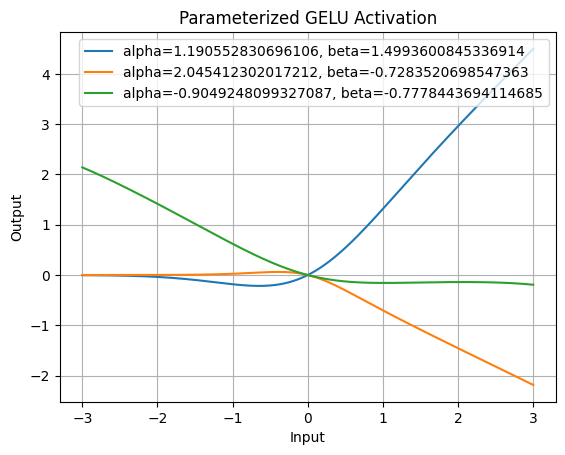

In [ ]:
# Generate input values
x_values = np.linspace(-3, 3, 400)  # Input range for GELU

# Compute GELU values for each alpha and beta
for alpha, beta in zip(alpha_values, beta_values):
    y_values = gelu(x_values, alpha, beta)

    # Plot the GELU function
    plt.plot(x_values, y_values, label=f'alpha={alpha}, beta={beta}')

plt.title('Parameterized GELU Activation')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
Test Loss: 0.7224696278572083, Test Accuracy: 0.8383200168609619 #normal
Test Loss: 0.6600239276885986, Test Accuracy: 0.8441600203514099 #trained